In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson

In [194]:
# Configurações
base_url = "https://dadosabertos.ccee.org.br"
api_endpoint = f"{base_url}/api/3/action/datastore_search"

# Lista de resource_ids que você forneceu
resource_ids = [
    "9e152b60-f75c-4219-bcee-6033d287e0ab",
    "6ccbf348-66ca-4bb1-a329-f607761fdf11",
    "f28d0cb3-1afa-4b55-bf90-71c68b28272a",
    "ed66d3dd-1987-4460-9164-20e169ad36fc",
    "8b81daa1-8155-4fe1-9ee3-e01beb42fcc8"
]

# Lista para armazenar os DataFrames
dfs = []

# Loop por cada resource_id
for rid in resource_ids:
    print(f"Carregando resource_id: {rid}...")

    params = {
        "resource_id": rid,
        "limit": 100000
    }

    response = requests.get(api_endpoint, params=params)

    if response.status_code == 200:
        data = response.json()
        records = data["result"]["records"]
        df_temp = pd.DataFrame(records)

        dfs.append(df_temp)
        print(f"   {len(records)} registros carregados.")
    else:
        print(f"   Erro ao carregar {rid}: {response.status_code}")

# Concatena todos os DataFrames
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"\nCONCLUÍDO! Total de registros no DataFrame final: {len(df)}")
    print(f"Colunas: {df.columns.tolist()}")

    # Exibe amostra
    print("\nPrimeiras 3 linhas:")
    display(df)
else:
    print("Nenhum dado foi carregado.")

Carregando resource_id: 9e152b60-f75c-4219-bcee-6033d287e0ab...
   1424 registros carregados.
Carregando resource_id: 6ccbf348-66ca-4bb1-a329-f607761fdf11...
   1444 registros carregados.
Carregando resource_id: f28d0cb3-1afa-4b55-bf90-71c68b28272a...
   1476 registros carregados.
Carregando resource_id: ed66d3dd-1987-4460-9164-20e169ad36fc...
   1464 registros carregados.
Carregando resource_id: 8b81daa1-8155-4fe1-9ee3-e01beb42fcc8...
   1296 registros carregados.

CONCLUÍDO! Total de registros no DataFrame final: 7104
Colunas: ['_id', 'MES_REFERENCIA', 'SUBMERCADO', 'DIA', 'PLD_MEDIA_DIA']

Primeiras 3 linhas:


,_id,MES_REFERENCIA,SUBMERCADO,DIA,PLD_MEDIA_DIA
0,1,202101,NORDESTE,08/01/2021,312.49
1,2,202101,NORTE,08/01/2021,312.49
2,3,202101,SUDESTE,08/01/2021,312.49
3,4,202101,SUL,08/01/2021,312.49
4,5,202101,NORDESTE,09/01/2021,291.06
...,...,...,...,...,...
7099,1292,202507,SUL,13/07/2025,115.53
7100,1293,202507,NORDESTE,14/07/2025,208.55
7101,1294,202507,NORTE,14/07/2025,210.16
7102,1295,202507,SUDESTE,14/07/2025,215.68


In [195]:
cols_desejadas = ['DIA', 'SUBMERCADO', 'PLD_MEDIA_DIA']
df_pld = df[cols_desejadas].copy()
df_pld = df_pld[df_pld['SUBMERCADO'] == 'SUDESTE'].reset_index(drop=True)

# Renomear colunas para padrão
df_pld = df_pld.rename(columns={
    'DIA': 'data',
    'SUBMERCADO': 'nom_subsistema',
    'PLD_MEDIA_DIA': 'pld_medio_diario'
})

df_pld['data'] = pd.to_datetime(df_pld['data'], format='%d/%m/%Y', errors='coerce').dt.date
df_pld = df_pld.drop_duplicates(subset='data', keep='first')

display(df_pld)

,data,nom_subsistema,pld_medio_diario
0,2021-01-08,SUDESTE,312.49
1,2021-01-09,SUDESTE,291.06
2,2021-01-10,SUDESTE,280.89
3,2021-01-11,SUDESTE,311.59
4,2021-01-12,SUDESTE,327.28
...,...,...,...
1771,2025-07-10,SUDESTE,194.65
1772,2025-07-11,SUDESTE,204.05
1773,2025-07-12,SUDESTE,122.67
1774,2025-07-13,SUDESTE,115.53


In [196]:
import pandas as pd

# ------------------------------------------------------------------
# Função para carregar CSV da ONS
# ------------------------------------------------------------------
def carregar_dataset(url_template, nome_dataset, anos=None):
    if anos is None:
        anos = range(2021, 2026)

    dfs = []
    for ano in anos:
        url = url_template.format(ano=ano)
        print(f"Carregando {nome_dataset} - {ano}...")
        try:
            df = pd.read_csv(url, sep=';')  # ONS usa encoding latin1
            dfs.append(df)
            print(f"   {df.shape[0]:,} linhas")
        except Exception as e:
            print(f"   Erro {ano}: {e}")

    if dfs:
        df_final = pd.concat(dfs, ignore_index=True)
        print(f"Total {nome_dataset}: {df_final.shape[0]:,} linhas")
        return df_final
    else:
        return pd.DataFrame()

# ------------------------------------------------------------------
# URLs (todos são CSV!)
# ------------------------------------------------------------------
urls = {
    'CMO_SEMIHORARIO': 'https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/cmo_tm/CMO_SEMIHORARIO_{ano}.csv',
    'EAR_Diario_por_Subsistema': 'https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_{ano}.csv',
    'ENA_Diario_por_Subsistema': 'https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_{ano}.csv',
    'Intercambio_Nacional': 'https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/intercambio_nacional_ho/INTERCAMBIO_NACIONAL_{ano}.csv'
}

# ------------------------------------------------------------------
# Carregar datasets
# ------------------------------------------------------------------
datasets = {}
for nome, url in urls.items():
    print(f"\n{'='*60}")
    print(f"CARREGANDO: {nome}")
    print(f"{'='*60}")
    datasets[nome] = carregar_dataset(url, nome)


CARREGANDO: CMO_SEMIHORARIO
Carregando CMO_SEMIHORARIO - 2021...
   69,696 linhas
Carregando CMO_SEMIHORARIO - 2022...
   67,008 linhas
Carregando CMO_SEMIHORARIO - 2023...
   67,392 linhas
Carregando CMO_SEMIHORARIO - 2024...
   69,504 linhas
Carregando CMO_SEMIHORARIO - 2025...
   60,288 linhas
Total CMO_SEMIHORARIO: 333,888 linhas

CARREGANDO: EAR_Diario_por_Subsistema
Carregando EAR_Diario_por_Subsistema - 2021...
   1,460 linhas
Carregando EAR_Diario_por_Subsistema - 2022...
   1,460 linhas
Carregando EAR_Diario_por_Subsistema - 2023...
   1,460 linhas
Carregando EAR_Diario_por_Subsistema - 2024...
   1,464 linhas
Carregando EAR_Diario_por_Subsistema - 2025...
   1,252 linhas
Total EAR_Diario_por_Subsistema: 7,096 linhas

CARREGANDO: ENA_Diario_por_Subsistema
Carregando ENA_Diario_por_Subsistema - 2021...
   1,460 linhas
Carregando ENA_Diario_por_Subsistema - 2022...
   1,460 linhas
Carregando ENA_Diario_por_Subsistema - 2023...
   1,460 linhas
Carregando ENA_Diario_por_Subsistem

In [197]:
import pandas as pd
from datetime import datetime

# ------------------------------------------------------------------
# 1. Processar cada dataset individualmente
# ------------------------------------------------------------------

# Lista para armazenar dataframes processados
dfs_processados = []

# ------------------------------
# CMO_SEMIHORARIO
# ------------------------------
if not datasets['CMO_SEMIHORARIO'].empty:
    df_cmo = datasets['CMO_SEMIHORARIO'].copy()
    df_cmo['din_instante'] = pd.to_datetime(df_cmo['din_instante'], errors='coerce')
    df_cmo['data'] = df_cmo['din_instante'].dt.date
    df_cmo = df_cmo.groupby(['data', 'nom_subsistema'], as_index=False)['val_cmo'].mean().round(2)
    df_cmo = df_cmo.rename(columns={'val_cmo': 'cmo_medio_diario'})
    df_cmo = df_cmo[['data', 'nom_subsistema', 'cmo_medio_diario']]
    dfs_processados.append(df_cmo)
    print("CMO processado")

# ------------------------------
# ENA_Diario_por_Subsistema
# ------------------------------
if not datasets['ENA_Diario_por_Subsistema'].empty:
    df_ena = datasets['ENA_Diario_por_Subsistema'].copy()
    df_ena['data'] = pd.to_datetime(df_ena['ena_data'], errors='coerce').dt.date
    df_ena = df_ena.rename(columns={'ena_armazenavel_regiao_percentualmlt': 'ena_armazenavel_perc'})
    df_ena = df_ena[['data', 'nom_subsistema', 'ena_armazenavel_perc']]
    dfs_processados.append(df_ena)
    print("ENA processado")

# ------------------------------
# EAR_Diario_por_Subsistema
# ------------------------------
if not datasets['EAR_Diario_por_Subsistema'].empty:
    df_ear = datasets['EAR_Diario_por_Subsistema'].copy()
    df_ear['data'] = pd.to_datetime(df_ear['ear_data'], errors='coerce').dt.date
    df_ear = df_ear.rename(columns={'ear_verif_subsistema_percentual': 'ear_verif_perc'})
    df_ear = df_ear[['data', 'nom_subsistema', 'ear_verif_perc']]
    dfs_processados.append(df_ear)
    print("EAR processado")

# ------------------------------
# Intercambio_Nacional - CÁLCULO LÍQUIDO
# ------------------------------
if not datasets['Intercambio_Nacional'].empty:
    df_int = datasets['Intercambio_Nacional'].copy()

    # Garantir que a coluna de data está em datetime
    df_int['din_instante'] = pd.to_datetime(df_int['din_instante'], errors='coerce')
    df_int['data'] = df_int['din_instante'].dt.date

    # Garantir que a coluna de valor é numérica
    df_int['val_intercambiomwmed'] = pd.to_numeric(df_int['val_intercambiomwmed'], errors='coerce')

    # Remover linhas com valores inválidos
    df_int = df_int.dropna(subset=['val_intercambiomwmed', 'nom_subsistema_origem', 'nom_subsistema_destino'])

    # Criar dois dataframes: um para exportação (positivo), outro para importação (negativo)
    df_export = df_int[['data', 'nom_subsistema_origem', 'val_intercambiomwmed']].copy()
    df_export = df_export.rename(columns={'nom_subsistema_origem': 'nom_subsistema'})
    df_export['val_intercambiomwmed'] = df_export['val_intercambiomwmed']  # positivo

    df_import = df_int[['data', 'nom_subsistema_destino', 'val_intercambiomwmed']].copy()
    df_import = df_import.rename(columns={'nom_subsistema_destino': 'nom_subsistema'})
    df_import['val_intercambiomwmed'] = -df_import['val_intercambiomwmed']  # negativo

    # Unir exportação e importação
    df_int_liquido = pd.concat([df_export, df_import], ignore_index=True)

    # Agregar por dia e subsistema: média horária → média diária
    df_int_liquido = (
        df_int_liquido
        .groupby(['data', 'nom_subsistema'], as_index=False)['val_intercambiomwmed']
        .mean()
        .round(2)
    )

    # Renomear coluna
    df_int_liquido = df_int_liquido.rename(columns={'val_intercambiomwmed': 'intercambio_liquido_mwmed'})

    # Adicionar à lista de dataframes processados
    dfs_processados.append(df_int_liquido)
    print("Intercâmbio Líquido processado com sucesso")
else:
    print("Intercambio_Nacional vazio ou não carregado")

# ------------------------------------------------------------------
# 2. Juntar todos os dataframes por (data, nom_subsistema)
# ------------------------------------------------------------------
if dfs_processados:
    df_final = dfs_processados[0]
    for df in dfs_processados[1:]:
        df_final = pd.merge(df_final, df, on=['data', 'nom_subsistema'], how='outer')

    # Ordenar por subsistema e data
    df_final['data'] = pd.to_datetime(df_final['data']).dt.date
    df_final = df_final.sort_values(['nom_subsistema', 'data']).reset_index(drop=True)

    # Opcional: filtrar apenas SUDESTE
    df_final = df_final[df_final['nom_subsistema'] == 'SUDESTE'].reset_index(drop=True)

    print(f"\nDF FINAL CRIADO: {df_final.shape[0]:,} linhas, {df_final.shape[1]} colunas")
    print("Colunas:", list(df_final.columns))
    print("Período:", df_final['data'].min(), "até", df_final['data'].max())
else:
    df_final = pd.DataFrame()
    print("Nenhum dataset processado com sucesso.")

# ------------------------------------------------------------------
# Exibir amostra
# ------------------------------------------------------------------
display(df_final.head(10))

CMO processado
ENA processado
EAR processado
Intercâmbio Líquido processado com sucesso

DF FINAL CRIADO: 1,776 linhas, 6 colunas
Colunas: ['data', 'nom_subsistema', 'cmo_medio_diario', 'ena_armazenavel_perc', 'ear_verif_perc', 'intercambio_liquido_mwmed']
Período: 2021-01-01 até 2025-11-11


,data,nom_subsistema,cmo_medio_diario,ena_armazenavel_perc,ear_verif_perc,intercambio_liquido_mwmed
0,2021-01-01,SUDESTE,202.80,62.149601,18.951799,-463.56
1,2021-01-02,SUDESTE,277.93,62.909698,19.163000,-341.56
2,2021-01-03,SUDESTE,269.37,63.787498,19.272100,-222.27
3,2021-01-04,SUDESTE,289.05,64.458900,19.523100,-750.27
4,2021-01-05,SUDESTE,292.23,65.278801,19.653099,-1254.17
5,2021-01-06,SUDESTE,292.30,65.229698,19.684700,-1157.92
6,2021-01-07,SUDESTE,309.62,63.944698,19.753401,-1155.34
7,2021-01-08,SUDESTE,294.02,63.695499,19.828600,-1111.14
8,2021-01-09,SUDESTE,354.30,63.772900,19.957701,-468.44
9,2021-01-10,SUDESTE,343.39,62.929798,20.064800,79.41


In [198]:
# Fazer o merge com o df_pld
df_final = df_final.merge(
    df_pld,
    on=['data', 'nom_subsistema'],
    how='left'
)

# Ordenar novamente
df_final = df_final.sort_values(['nom_subsistema', 'data']).reset_index(drop=True)
df_final = df_final.dropna()



display(df_final.head(10))
print("Período:", df_final['data'].min(), "até", df_final['data'].max())

,data,nom_subsistema,cmo_medio_diario,ena_armazenavel_perc,ear_verif_perc,intercambio_liquido_mwmed,pld_medio_diario
7,2021-01-08,SUDESTE,294.02,63.695499,19.828600,-1111.14,312.49
8,2021-01-09,SUDESTE,354.30,63.772900,19.957701,-468.44,291.06
9,2021-01-10,SUDESTE,343.39,62.929798,20.064800,79.41,280.89
10,2021-01-11,SUDESTE,378.17,63.828999,20.105600,-368.32,311.59
11,2021-01-12,SUDESTE,391.74,63.785801,20.272699,-486.11,327.28
12,2021-01-13,SUDESTE,392.53,64.061897,20.496700,-722.15,328.37
13,2021-01-14,SUDESTE,372.34,65.795700,20.761000,-1287.98,307.35
14,2021-01-15,SUDESTE,352.19,66.674797,20.998199,-1249.36,296.27
15,2021-01-16,SUDESTE,213.67,67.625000,21.247801,-643.95,211.70
16,2021-01-17,SUDESTE,211.24,66.199402,21.582001,-1008.68,208.33


Período: 2021-01-08 até 2025-11-09


- **data**: data da observação (formato YYYY-MM-DD)
- **nom_subsistema**: nome do subsistema elétrico (ex: SUDESTE)
- **cmo_medio_diario**: Custo Marginal de Operação médio diário (PLD, em R$/MWh)
- **ena_armazenavel_perc**: Energia Natural Afluente armazenável (% da MLT – média de longo termo)
- **ear_verif_perc**: Energia Armazenada Real verificada (% da capacidade máxima útil)
- **intercambio_liquido_mwmed**: intercâmbio líquido de energia com outros subsistemas (MW médios; negativo = importação, positivo = exportação)

- **pld_medio_diario**: Preço de Liquidação das Diferenças médio do dia (R$/MWh)

Os dados foram filtrados para apenas a região sudeste. As variáveis principais aqui analisadas são o CMO e o PLD.

In [199]:
print("=== ANÁLISE DE MERCADO: RELAÇÃO ENTRE PLD, CMO E VARIÁVEIS OPERACIONAIS ===")

# 1. Estatísticas Descritivas
print("1. ESTATÍSTICAS DESCRITIVAS DAS VARIÁVEIS CHAVE")
desc = df_final[['cmo_medio_diario', 'pld_medio_diario', 'ena_armazenavel_perc',
                 'ear_verif_perc', 'intercambio_liquido_mwmed']].describe()
print(desc.round(2))

=== ANÁLISE DE MERCADO: RELAÇÃO ENTRE PLD, CMO E VARIÁVEIS OPERACIONAIS ===
1. ESTATÍSTICAS DESCRITIVAS DAS VARIÁVEIS CHAVE
       cmo_medio_diario  pld_medio_diario  ena_armazenavel_perc  \
count           1729.00           1729.00               1729.00   
mean             176.37            150.14                 73.29   
std              387.55            144.55                 17.77   
min                0.00             49.78                 34.27   
25%                0.04             61.07                 59.76   
50%               53.87             69.04                 70.46   
75%              190.93            203.23                 84.69   
max             3092.02            716.80                132.13   

       ear_verif_perc  intercambio_liquido_mwmed  
count         1729.00                    1729.00  
mean            55.74                   -1959.83  
std             19.03                     848.80  
min             16.51                   -4552.11  
25%             4

Não foi encontrada anomalia nos dados. A região sudeste costuma ficar em déficit de geração de energia elétrica em relação a outras regiões, de acordo com intercambio_liquido_mwmed.

In [200]:
print("\nExemplo de duplicatas:")
print(df_final[df_final['data'].duplicated(keep=False)].sort_values('data').head(10))


Exemplo de duplicatas:
Empty DataFrame
Columns: [data, nom_subsistema, cmo_medio_diario, ena_armazenavel_perc, ear_verif_perc, intercambio_liquido_mwmed, pld_medio_diario]
Index: []


In [201]:
# === 1. RESAMPLE MENSAL (Média mensal) ===
# Garantir que a coluna 'data' seja datetime
df_final['data'] = pd.to_datetime(df_final['data'], errors='coerce')

# Definir como índice e garantir frequência diária
df_final = df_final.set_index('data')

# Resample mensal (média) - agora vai funcionar
df_mensal = df_final[['cmo_medio_diario', 'pld_medio_diario', 'ena_armazenavel_perc', 'ear_verif_perc', 'intercambio_liquido_mwmed']].resample('MS').mean()

# Ajustar índice para o primeiro dia do mês
df_mensal.index = df_mensal.index.to_period('M').to_timestamp()

# Garantir frequência mensal explícita
df_mensal = df_mensal.asfreq('MS')

print("1. DADOS RESAMPLADOS PARA MÉDIA MENSAL")
print(df_mensal.head())
print(f"\nPeríodo mensal: {df_mensal.index.min().strftime('%Y-%m')} até {df_mensal.index.max().strftime('%Y-%m')}")
print(f"Observações mensais: {len(df_mensal)}\n")

1. DADOS RESAMPLADOS PARA MÉDIA MENSAL
            cmo_medio_diario  pld_medio_diario  ena_armazenavel_perc  \
data                                                                   
2021-01-01        248.305833        231.178750             69.140004   
2021-02-01        162.271429        165.984286             67.655267   
2021-03-01        117.712903        109.023871             66.436300   
2021-04-01        139.322333        132.627000             55.112390   
2021-05-01        242.790645        218.701290             60.049991   

            ear_verif_perc  intercambio_liquido_mwmed  
data                                                   
2021-01-01       21.880008               -1184.541250  
2021-02-01       26.062218               -1140.638929  
2021-03-01       33.178187               -1598.422581  
2021-04-01       35.271273               -1422.146000  
2021-05-01       33.273162               -1141.945484  

Período mensal: 2021-01 até 2025-11
Observações mensais: 59



Resample mensal para fazer a posterior decomposição temporal da série e identificar tendência, sazonalidade etc.


2. MATRIZ DE CORRELAÇÃO (PEARSON)


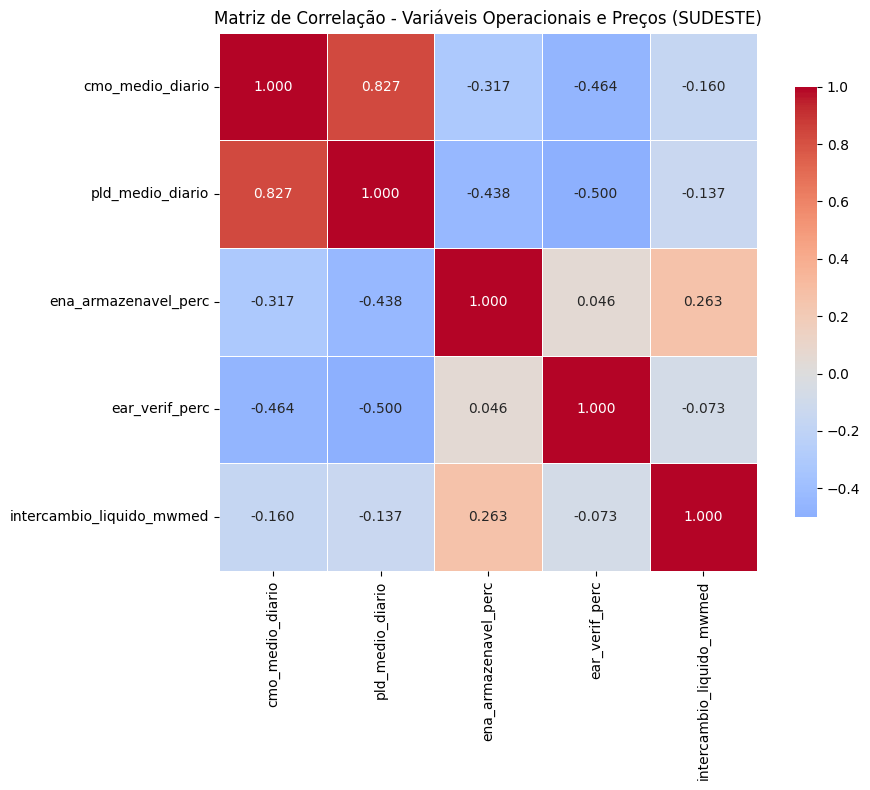

Correlações com PLD médio diário:
pld_medio_diario             1.000
cmo_medio_diario             0.827
intercambio_liquido_mwmed   -0.137
ena_armazenavel_perc        -0.438
ear_verif_perc              -0.500
Name: pld_medio_diario, dtype: float64

Correlações com CMO médio diário:
cmo_medio_diario             1.000
pld_medio_diario             0.827
intercambio_liquido_mwmed   -0.160
ena_armazenavel_perc        -0.317
ear_verif_perc              -0.464
Name: cmo_medio_diario, dtype: float64


In [202]:
# 2. Análise de Correlação
print("\n2. MATRIZ DE CORRELAÇÃO (PEARSON)")
vars_cor = ['cmo_medio_diario', 'pld_medio_diario', 'ena_armazenavel_perc',
            'ear_verif_perc', 'intercambio_liquido_mwmed']
corr_matrix = df_mensal[vars_cor].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação - Variáveis Operacionais e Preços (SUDESTE)')
plt.tight_layout()
plt.show()

# Destacar correlações fortes com PLD e CMO
print("Correlações com PLD médio diário:")
pld_corr = corr_matrix['pld_medio_diario'].sort_values(ascending=False)
print(pld_corr.round(3))

print("\nCorrelações com CMO médio diário:")
cmo_corr = corr_matrix['cmo_medio_diario'].sort_values(ascending=False)
print(cmo_corr.round(3))

Alta correlação entre o CMO e o PLD. Correlação muito baixa entre variáveis hídricas (ena_armazenavel_perc, ear_verif_perc), excedente de energia gerada (intercambio_liquido_mwmed) com as variáveis de interesse (CMO e PLD). Isso pode sugerir uma correlação não linear e/ou impacto com defasagem (lag).


3. ANÁLISE TEMPORAL DAS SÉRIES


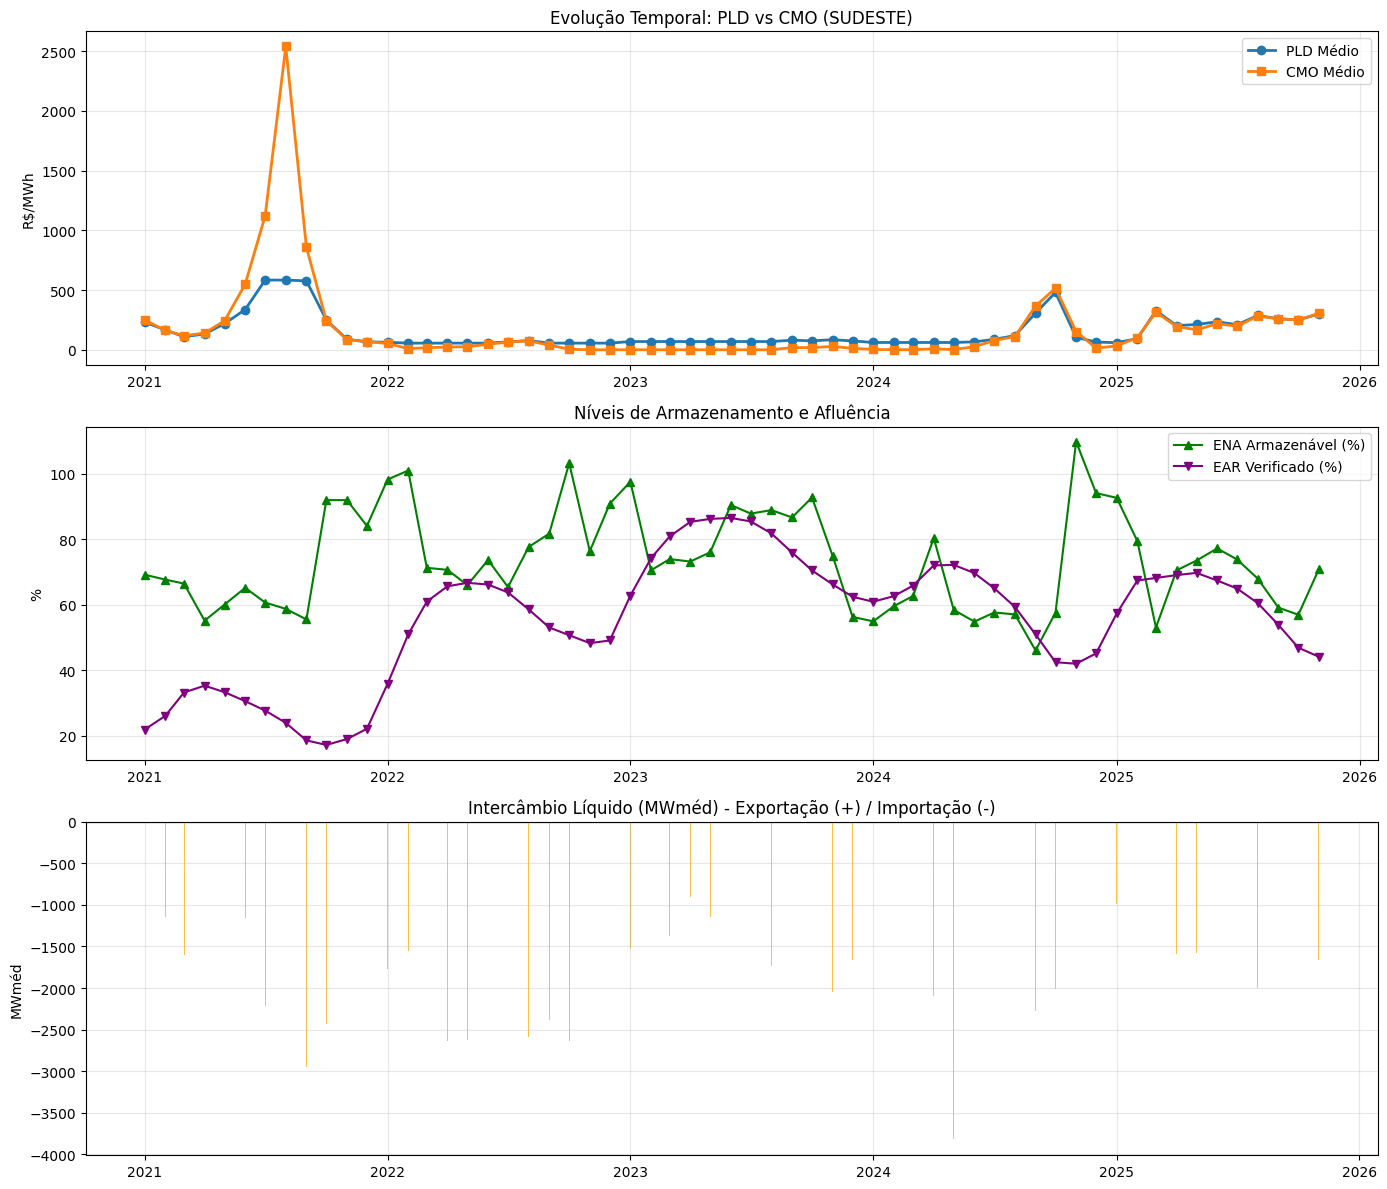

In [203]:
# 3. Análise Temporal e Tendências
print("\n3. ANÁLISE TEMPORAL DAS SÉRIES")

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# PLD vs CMO
axes[0].plot(df_mensal.index, df_mensal['pld_medio_diario'], label='PLD Médio', marker='o', linewidth=2)
axes[0].plot(df_mensal.index, df_mensal['cmo_medio_diario'], label='CMO Médio', marker='s', linewidth=2)
axes[0].set_title('Evolução Temporal: PLD vs CMO (SUDESTE)')
axes[0].set_ylabel('R$/MWh')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Armazenamento e ENA
axes[1].plot(df_mensal.index, df_mensal['ena_armazenavel_perc'], label='ENA Armazenável (%)', color='green', marker='^')
axes[1].plot(df_mensal.index, df_mensal['ear_verif_perc'], label='EAR Verificado (%)', color='purple', marker='v')
axes[1].set_title('Níveis de Armazenamento e Afluência')
axes[1].set_ylabel('%')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Intercâmbio Líquido
axes[2].bar(df_mensal.index, df_mensal['intercambio_liquido_mwmed'], color='orange', alpha=0.7)
axes[2].axhline(0, color='black', linewidth=0.8)
axes[2].set_title('Intercâmbio Líquido (MWméd) - Exportação (+) / Importação (-)')
axes[2].set_ylabel('MWméd')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

2021 - PLD e CMO muito próximos, com pico explosivo no final de 2021 (~R$ 2.500/MWh). Crise hídrica grave → despacho térmico intenso.

In [204]:
# 4. Relação PLD x CMO + variáveis (Regressão com statsmodels)
print("\n4. RELAÇÃO PLD vs CMO + VARIÁVEIS (REGRESSÃO LINEAR - STATSMODELS)")

# Variáveis explicativas
X = df_mensal[['cmo_medio_diario', 'ena_armazenavel_perc',
               'ear_verif_perc', 'intercambio_liquido_mwmed']]

# Adiciona constante para o intercepto
X_const = sm.add_constant(X)

# 1. Transformar PLD
df_mensal['PLD_log'] = np.log(df_mensal['pld_medio_diario'] + 1)

# Variável dependente
y = df_mensal['PLD_log']

# Ajusta o modelo
model_sm = sm.OLS(y, X_const).fit(cov_type='HAC', cov_kwds={'maxlags': 12})

# Predições
y_pred = model_sm.predict(X_const)

# R²
r2 = model_sm.rsquared
print(f"R²: {r2:.4f}")

# Resumo completo da regressão
print(model_sm.summary())

# Interpretação prática da inclinação do CMO
coef_cmo = model_sm.params['cmo_medio_diario']
pval_cmo = model_sm.pvalues['cmo_medio_diario']

# --- Interpretação percentual (aproximação válida para β pequeno) ---
percentual = coef_cmo * 100
print(f"\n  INTERPRETAÇÃO EM VARIAÇÃO PERCENTUAL:")
print(f"  → A cada R$1 de aumento no CMO,")
print(f"    o PLD aumenta aproximadamente **{percentual:.3f}%** (em média)")

# --- Interpretação exata (multiplicativa) ---
fator_multiplicativo = np.exp(coef_cmo)
print(f"\n  INTERPRETAÇÃO EXATA (multiplicativa):")
print(f"  → Um aumento de R$1 no CMO **multiplica** o PLD por:")
print(f"    e^(β) = {fator_multiplicativo:.5f}")
print(f"    → PLD_novo ≈ PLD_antigo × {fator_multiplicativo:.5f}")

# Intercepto
print(f"  - Intercepto: {model_sm.params['const']:.2f}")


4. RELAÇÃO PLD vs CMO + VARIÁVEIS (REGRESSÃO LINEAR - STATSMODELS)
R²: 0.6108
                            OLS Regression Results                            
Dep. Variable:                PLD_log   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     70.90
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           7.62e-21
Time:                        14:18:29   Log-Likelihood:                -36.564
No. Observations:                  59   AIC:                             83.13
Df Residuals:                      54   BIC:                             93.52
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

Regressão linear robusta para mitigar autocorrelação e heterocedasticidade e realizar inferência causal. Todas as variáveis menos o intercambio_liquido_mwmed foram significantes (confiança de 95%) para explicar a variação do PLD. A regressão tem um Rquadrado ajustado de 0.582 que indica um decente fit do modelo, embora há espaço para adicionar explicabilidade com a inclusão de mais variáveis. De acordo com o modelo, a cada aumento de R$1 no CMO, o PLD aumenta em média 0.101%.

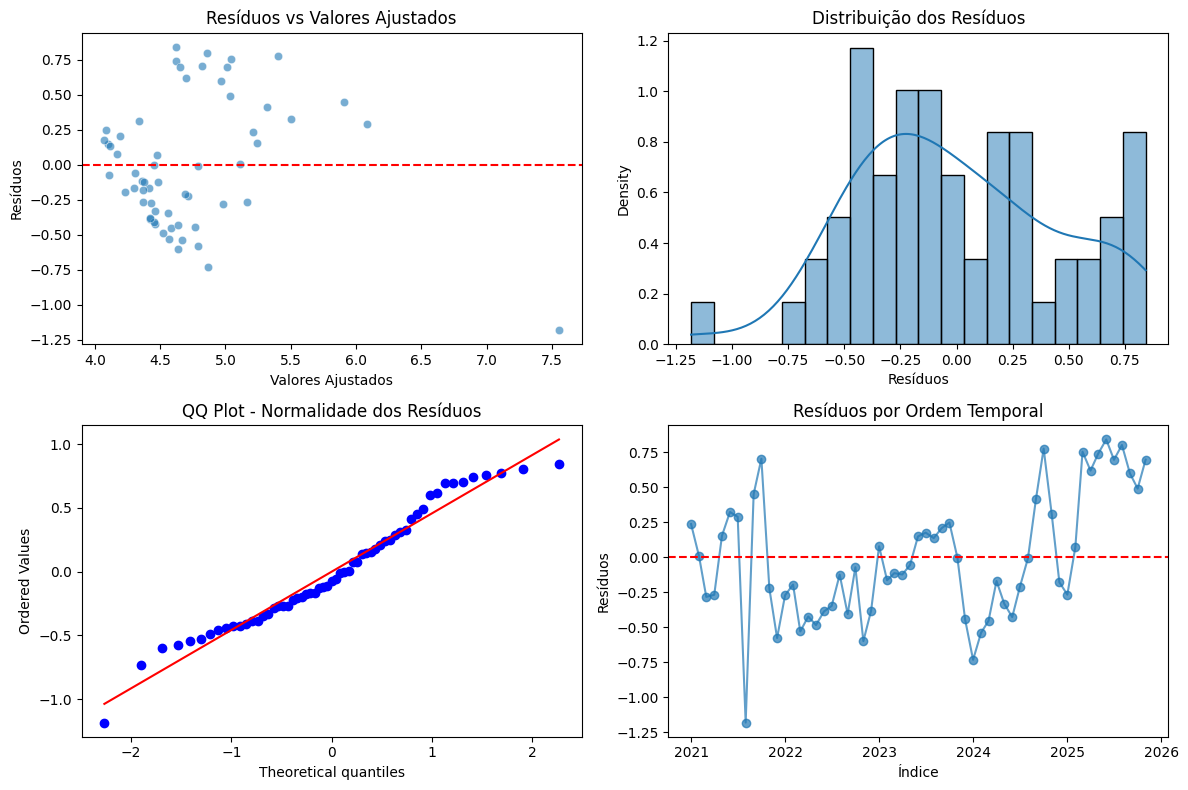

In [206]:
# Resíduos
residuals = model_sm.resid
fitted = model_sm.fittedvalues

# 1. Gráfico: Resíduos vs Valores Ajustados
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(x=fitted, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')

# 2. Histograma dos resíduos
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, bins=20, stat="density")
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')

# 3. QQ Plot
plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot - Normalidade dos Resíduos')

# 4. Resíduos vs Ordem (para série temporal)
plt.subplot(2, 2, 4)
plt.plot(residuals, marker='o', linestyle='-', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos por Ordem Temporal')
plt.xlabel('Índice')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()

In [207]:
print("\n" + "="*60)
print("DIAGNÓSTICOS DOS RESÍDUOS")
print("="*60)

# 1. Teste de Normalidade (Shapiro-Wilk)
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk (normalidade): W = {shapiro_stat:.4f}, p-valor = {shapiro_p:.4f}")
print(f"→ {'Normal' if shapiro_p > 0.05 else 'NÃO normal'} (p > 0.05)")

# 2. Teste de Autocorrelação (Durbin-Watson)
dw = durbin_watson(residuals)
print(f"\nDurbin-Watson (autocorrelação): {dw:.3f}")
print(f"→ ~2.0 = sem autocorrelação | <1.5 ou >2.5 = problema")

# 3. Teste de Heterocedasticidade (Breusch-Pagan)
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_const)
print(f"\nBreusch-Pagan (heterocedasticidade): p-valor = {bp_p:.4f}")
print(f"→ {'Homocedástico' if bp_p > 0.05 else 'Heterocedástico'} (p > 0.05)")

# 4. Teste White (mais geral)
white_stat, white_p, _, _ = het_white(residuals, X_const)
print(f"White (heterocedasticidade): p-valor = {white_p:.4f}")


DIAGNÓSTICOS DOS RESÍDUOS
Shapiro-Wilk (normalidade): W = 0.9657, p-valor = 0.0952
→ Normal (p > 0.05)

Durbin-Watson (autocorrelação): 0.795
→ ~2.0 = sem autocorrelação | <1.5 ou >2.5 = problema

Breusch-Pagan (heterocedasticidade): p-valor = 0.0000
→ Heterocedástico (p > 0.05)
White (heterocedasticidade): p-valor = 0.0000


Há evidência de que a regressão possui resíduos aproximadamente normais, porém há forte autocorrelação e heterocedasticidade, por isso é utilizado os erros-padrão robustos HAC para mitigar o problema. Um modelo com variáveis autorregressivas pode ser necessário.

1. DECOMPOSIÇÃO: CMO MÉDIO DIÁRIO


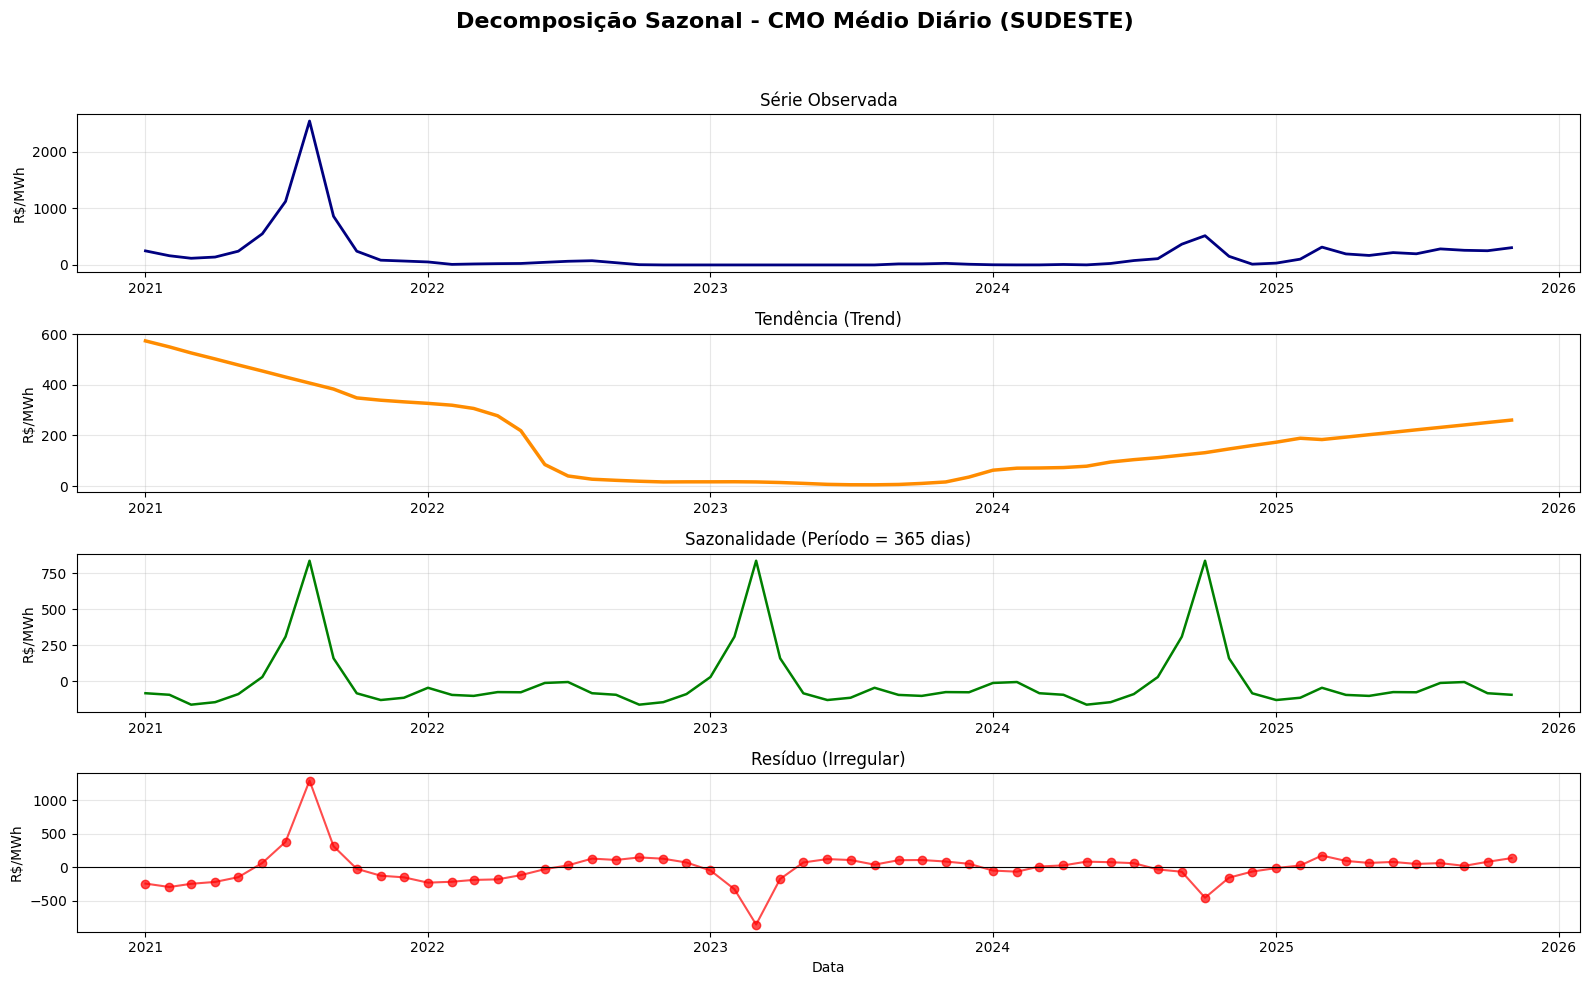

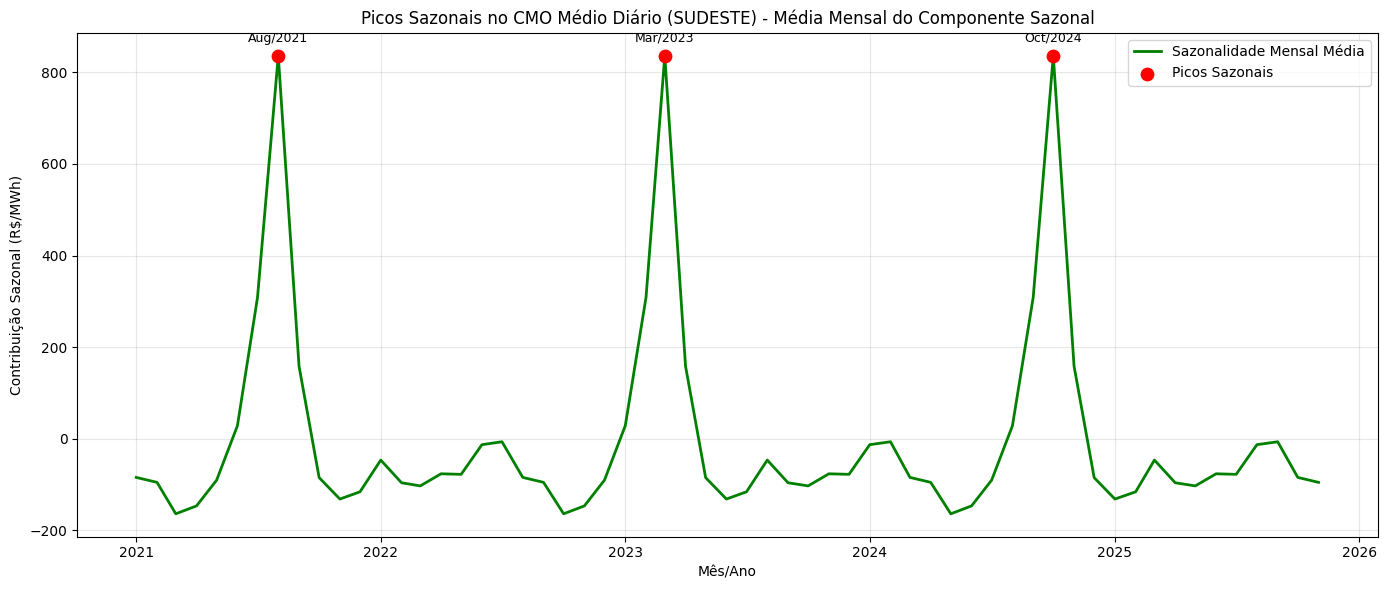

In [208]:
# === FUNÇÃO PARA DECOMPOSIÇÃO E PLOT ===
def decompose_and_plot(series, title, period=30, model='additive'):
    """
    Realiza decomposição sazonal e plota componentes
    """
    # Remover NaNs (caso haja)
    series = series.dropna()

    # Decomposição (STL-like via statsmodels)
    try:
        result = seasonal_decompose(series, model=model, period=period, extrapolate_trend='freq')
    except:
        # Fallback com período mínimo se falhar
        result = seasonal_decompose(series, model=model, period=min(period, len(series)//3), extrapolate_trend='freq')

    # Extrair componente sazonal
    seasonal = result.seasonal

    # Encontrar picos no componente sazonal mensal
    peaks, _ = find_peaks(seasonal, height=seasonal.mean(), distance=3)
    peak_dates = seasonal.index[peaks]
    peak_values = seasonal.iloc[peaks]

    # Plot
    fig, axes = plt.subplots(4, 1, figsize=(16, 10))
    fig.suptitle(f'Decomposição Sazonal - {title}', fontsize=16, fontweight='bold', y=0.98)

    # Série original
    axes[0].plot(result.observed.index, result.observed, color='navy', linewidth=2)
    axes[0].set_title('Série Observada')
    axes[0].set_ylabel('R$/MWh')
    axes[0].grid(True, alpha=0.3)

    # Tendência
    axes[1].plot(result.trend.index, result.trend, color='darkorange', linewidth=2.5)
    axes[1].set_title('Tendência (Trend)')
    axes[1].set_ylabel('R$/MWh')
    axes[1].grid(True, alpha=0.3)

    # Sazonalidade
    axes[2].plot(result.seasonal.index, result.seasonal, color='green', linewidth=1.8)
    axes[2].set_title(f'Sazonalidade (Período = {period} dias)')
    axes[2].set_ylabel('R$/MWh')
    axes[2].grid(True, alpha=0.3)

    # Resíduo
    axes[3].plot(result.resid.index, result.resid, color='red', marker='o', linestyle='-', alpha=0.7)
    axes[3].axhline(0, color='black', linewidth=0.8)
    axes[3].set_title('Resíduo (Irregular)')
    axes[3].set_ylabel('R$/MWh')
    axes[3].set_xlabel('Data')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot do componente sazonal mensal com picos
    plt.figure(figsize=(14, 6))
    plt.plot(seasonal.index, seasonal, label='Sazonalidade Mensal Média', color='green', linewidth=2)
    plt.scatter(peak_dates, peak_values, color='red', s=80, zorder=5, label='Picos Sazonais')
    for date, val in zip(peak_dates, peak_values):
        plt.annotate(date.strftime('%b/%Y'), (date, val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    plt.title(f'Picos Sazonais no {title} - Média Mensal do Componente Sazonal')
    plt.ylabel('Contribuição Sazonal (R$/MWh)')
    plt.xlabel('Mês/Ano')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return result, peak_dates, peak_values

# === 1. DECOMPOSIÇÃO DO CMO ===
print("1. DECOMPOSIÇÃO: CMO MÉDIO DIÁRIO")
cmo_result, cmo_peaks, cmo_vals = decompose_and_plot(
    df_mensal['cmo_medio_diario'],
    title='CMO Médio Diário (SUDESTE)',
    period=365,
    model='additive'
)


2. DECOMPOSIÇÃO: PLD MÉDIO DIÁRIO


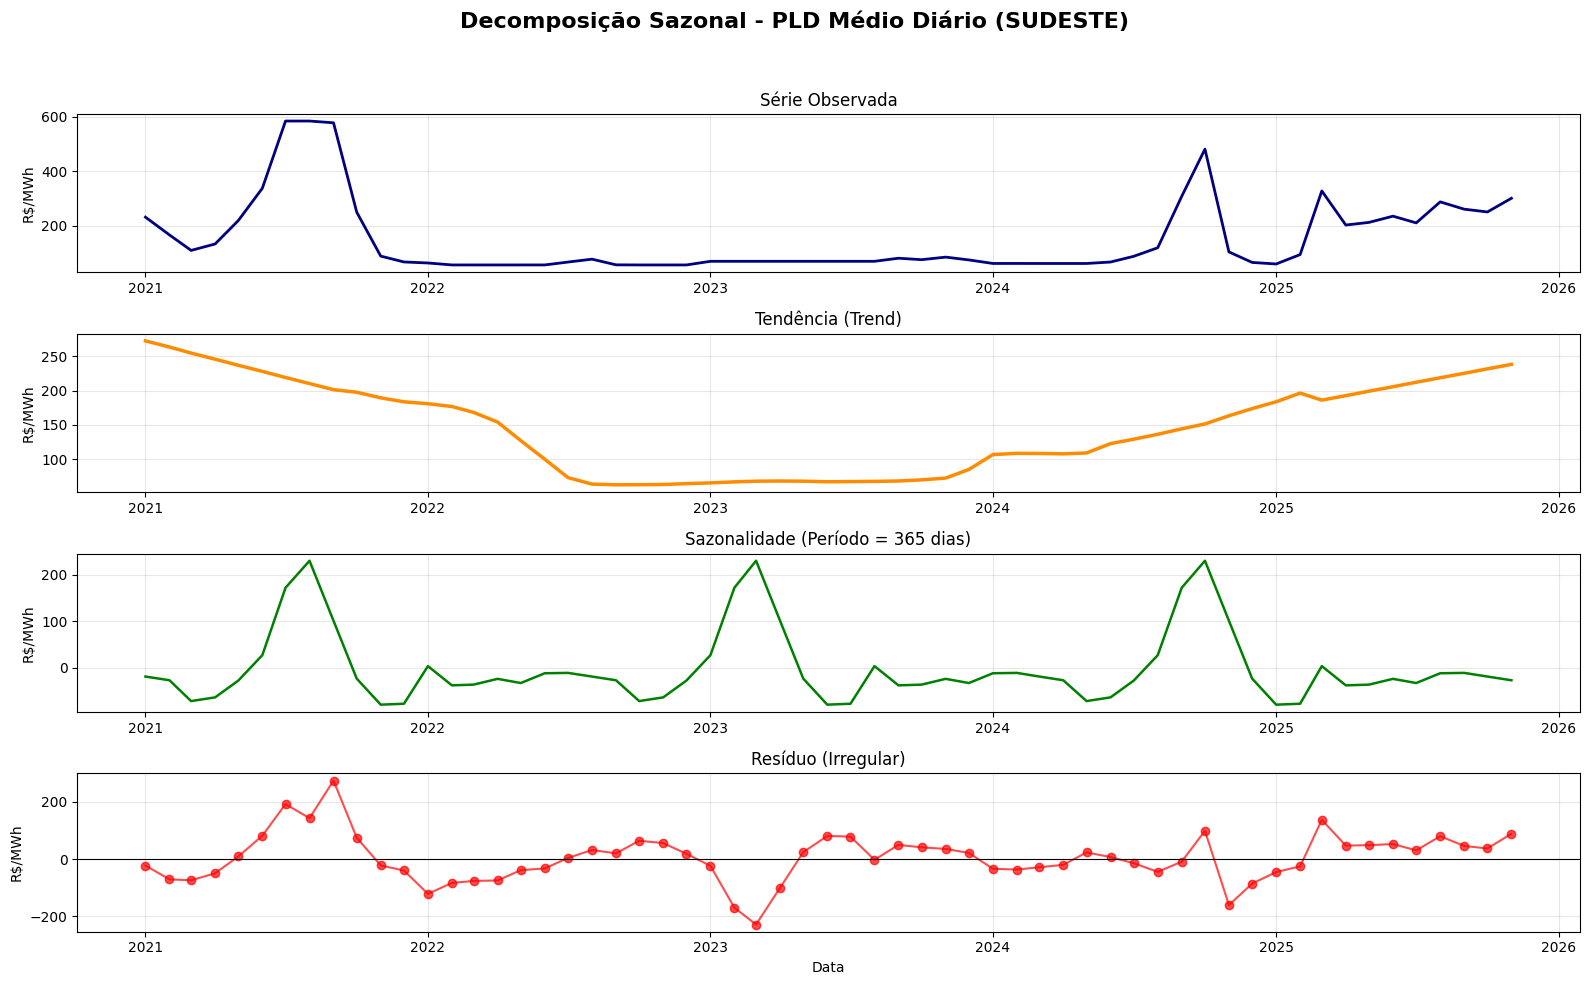

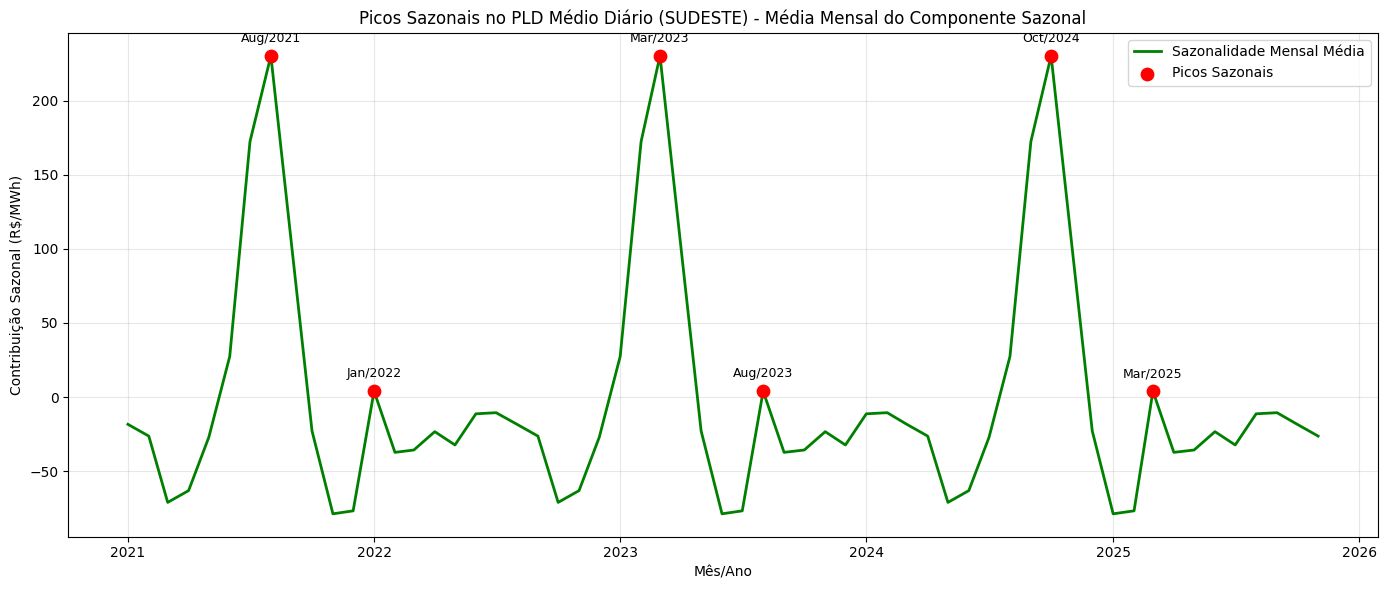

In [209]:
# === 2. DECOMPOSIÇÃO DO PLD ===
print("\n2. DECOMPOSIÇÃO: PLD MÉDIO DIÁRIO")
pld_result, pld_peaks, pld_vals = decompose_and_plot(
    df_mensal['pld_medio_diario'],
    title='PLD Médio Diário (SUDESTE)',
    period=365,
    model='additive'
)

Modelo aditivo captura bem a sazonalidade anual e a tendência geral, mas o resíduo mostra que ainda falta explicar choques (crise 2021, recuperação 2024). Série tem forte componente sazonal seca/úmida, tendência não linear e eventos extremos.

Ciclo anual claro:

Pico todo fim de seca (ago/set) e início de chuva (dez/jan)

Vale no meio da chuvosa (mar/abr)

Sazonalidade explica boa parte da variação anual do PLD.

In [210]:
# === 3. ANÁLISE DOS COMPONENTES ===
print("\n" + "="*70)
print("ANÁLISE DOS COMPONENTES DA DECOMPOSIÇÃO")
print("="*70)

def analyze_components(result, name, peak_dates):
    trend = result.trend.dropna()
    seasonal = result.seasonal
    resid = result.resid.dropna()

    print(f"\n{name.upper()}:")
    print(f"   • Tendência média: {trend.mean():.2f} R$/MWh")
    print(f"   • Variação da tendência: ±{trend.std():.2f}")
    print(f"   • Amplitude sazonal: {seasonal.max() - seasonal.min():.2f}")
    print(f"   • Desvio padrão do resíduo: {resid.std():.2f}")
    print(f"   • % explicado pela tendência: {(trend.var() / result.observed.var())*100:.1f}%")
    print(f"   • % explicado pela sazonalidade: {(seasonal.var() / result.observed.var())*100:.1f}%")
    print(f"   • % explicado pelo resíduo: {(resid.var() / result.observed.var())*100:.1f}%")

    if len(peak_dates) > 0:
            print(f"\n   PICOS SAZONAIS DETECTADOS (média mensal do componente sazonal):")

            # === MÉTODO de usar .asof() para encontrar o valor mais próximo ===
            monthly_seasonal = result.seasonal.resample('ME').mean()

            for peak_date in peak_dates:
                # Encontra o último dia do mês do pico (ou o mais próximo)
                month_end = pd.offsets.MonthEnd(0).rollback(peak_date)
                # Usa .asof() para pegar o valor mais próximo (compatível)
                val = monthly_seasonal.asof(month_end)
                print(f"     → {peak_date.strftime('%b/%Y')}: +{val:.1f} R$/MWh (contribuição sazonal)")
    else:
        print("\n   Nenhum pico sazonal detectado.")

    print(f"{'='*70}")

analyze_components(cmo_result, "CMO", cmo_peaks)
analyze_components(pld_result, "PLD", pld_peaks)


ANÁLISE DOS COMPONENTES DA DECOMPOSIÇÃO

CMO:
   • Tendência média: 182.12 R$/MWh
   • Variação da tendência: ±164.88
   • Amplitude sazonal: 1000.27
   • Desvio padrão do resíduo: 255.21
   • % explicado pela tendência: 19.2%
   • % explicado pela sazonalidade: 35.5%
   • % explicado pelo resíduo: 46.1%

   PICOS SAZONAIS DETECTADOS (média mensal do componente sazonal):
     → Aug/2021: +308.7 R$/MWh (contribuição sazonal)
     → Mar/2023: +308.7 R$/MWh (contribuição sazonal)
     → Oct/2024: +308.7 R$/MWh (contribuição sazonal)

PLD:
   • Tendência média: 147.08 R$/MWh
   • Variação da tendência: ±66.33
   • Amplitude sazonal: 309.37
   • Desvio padrão do resíduo: 84.45
   • % explicado pela tendência: 22.8%
   • % explicado pela sazonalidade: 32.8%
   • % explicado pelo resíduo: 36.9%

   PICOS SAZONAIS DETECTADOS (média mensal do componente sazonal):
     → Aug/2021: +172.5 R$/MWh (contribuição sazonal)
     → Jan/2022: +-76.9 R$/MWh (contribuição sazonal)
     → Mar/2023: +172.5 

In [ ]:
df_mensal.to_csv('pergunta_2/df_mensal.csv', index=False)